In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import xgboost as xgb

import constants

# Data Functions

In [2]:
def load_static_data():
    static_sensor_data=[]
    for sensor in constants.SENSOR_IDS:
        list_ = []
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/static/{}/{}.csv".format(date, sensor)
            df = pd.read_csv(filename,index_col=None)
            df['lat'] = constants.STATIC_COORDS[sensor][0]
            df['long'] = constants.STATIC_COORDS[sensor][1]
            # Calibration
            df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
            df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
            df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
            df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
            df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
            # -----------
            list_.append(df)
        static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))
    all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
    # Select columns
    all_static_data = all_static_data[constants.COLUMNS]
    all_static_data = all_static_data.dropna()
    return all_static_data

def load_mobile_sensors():
    list_ = []
    for sensor in constants.MOBILE_SENSORS:
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/personal/{}/{}_{}.csv".format(date, sensor, date)
            df = pd.read_csv(filename,index_col=None)
            list_.append(df)
        mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
        mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
        mobile_sensor_data['long'] = mobile_sensor_data['longitude']
        # Calibration
        df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
        df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
        df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
        df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
        df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
        #Select columns
        mobile_sensor_data = mobile_sensor_data[constants.COLUMNS]
    return mobile_sensor_data

#Transform to grid coordinates
def grid_lat_coord(lat):
    if lat < 55.93814 or lat > 55.94686:
        return -1
    i = 0
    for lat_check in np.linspace(55.93814,55.94686,constants.GRID_SIZE+1)[1:]:
        if lat < lat_check:
            return 19-i
        i+=1

def grid_long_coord(long):
    if long < -3.19665 or long > -3.18123:
        return -1
    i = 0
    for long_check in np.linspace(-3.19665,-3.18123,constants.GRID_SIZE+1)[1:]:
        if long < long_check:
            return i
        i+=1

def transform_to_grid_coordinates(data):
    data['lat_grid'] = data['lat'].apply(grid_lat_coord)
    data['long_grid'] = data['long'].apply(grid_long_coord)
    data = data[data['lat_grid'] >= 0]
    data = data[data['long_grid'] >= 0]
    return data

def add_land_type(data):
    data['land_type'] = np.vectorize(get_land_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['land_type'])
    data = data.join(one_hot)
    data.rename(columns={1.0: 'commercial', 2.0: 'residential', 3.0: 'green'}, inplace=True)
    data.drop(['land_type'],axis=1, inplace=True)
    
    return data

def get_land_type(x, y):
    return landuse[int(x)][int(y)]

def add_road_type(data):
    osm_dir = "/Users/ryanegan/Documents/diss/projectZoe/data/osm/"
    road_file = osm_dir + "roadtype_grid" + str(constants.GRID_SIZE) + ".csv"

    pd_df2=pd.read_csv(road_file, sep=',',header=None, skiprows=1)
    roadtype = pd_df2.values
    
    data['road_type'] = np.vectorize(get_road_type)(data['lat_grid'], data['long_grid'])
    
    one_hot = pd.get_dummies(data['road_type'])
    data = data.join(one_hot)
    data.rename(columns={0.0: 'primary', 1.0: 'secondary', 2.0: 'tertiary', 3.0: 'unclassified', 4.0: 'residential/service', 5.0: 'pedestrian/cycle/noroad'}, inplace=True)
    data.drop(['road_type'],axis=1, inplace=True)
    
    return data

def get_road_type(x, y):
    return roadtype[int(x)][int(y)]

def add_labels(data):
    data['prev_pm_2.5'] = np.vectorize(get_previous_pm)(data['lat_grid'], data['long_grid'], data['timestep'])
    return data

def get_previous_pm(lat, long, timestep):
    for i in range(constants.GRID_SIZE):
        prev_data = all_data[(np.abs(all_data['lat_grid'] - lat) <= i) & (np.abs(all_data['long_grid'] - long) <= i) & (all_data['timestep'] == timestep - 1)]
        if(not prev_data.empty):
            prev_pm = prev_data['PM2.5'].mean()
            return prev_pm
    
def setIds(data):
    startTime = constants.START_TIME
    endTime = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=5)).strftime("%Y-%m-%d %H:%M:%S")
    i = 0
    j=0
    data['timestep'] = ''
    data['timestepContinuous'] = ''
    
    while startTime < constants.END_TIME:
        
        data['timestep'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(i), data['timestep'])
        i+=1
        
        if (data[(data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime)].shape[0] != 0):
            data['timestepContinuous'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(j), data['timestepContinuous'])
            j+=1
        startTime = endTime
        endTime = (datetime.strptime(endTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=constants.WINDOW)).strftime("%Y-%m-%d %H:%M:%S")
        

# LOAD DATA

In [3]:
# staticData = load_static_data()
# staticData = transform_to_grid_coordinates(staticData)
# mobileData = load_mobile_sensors()
# mobileData = transform_to_grid_coordinates(mobileData)
# allData = pd.concat([staticData, mobileData], ignore_index=True)
# setIds(staticData)
# setIds(allData)
# allData

osm_dir = "/Users/ryanegan/Documents/diss/projectZoe/data/osm/"
LU_file = osm_dir + "landuse_grid" + str(constants.GRID_SIZE) + ".csv"
road_file = osm_dir + "roadtype_grid" + str(constants.GRID_SIZE) + ".csv"

pd_df1=pd.read_csv(LU_file, sep=',',header=None, skiprows=1)
landuse = pd_df1.values
pd_df2=pd.read_csv(road_file, sep=',',header=None, skiprows=1)
roadtype = pd_df2.values

with open("all_data_15_min.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)

all_data.drop(['mobile'], axis=1, inplace = True)


all_data = add_land_type(all_data)
all_data = add_road_type(all_data)
all_data = add_labels(all_data).dropna()
# all_data = add_previous_pm(all_data)

all_data = all_data.dropna()

# Model Functions

In [4]:
#TODO add params for activations, num layers, width of layers, optimizer, loss function, learning rate, batch size
def createStationaryModel():
    online_model = tf.keras.Sequential([
        layers.Dense(16, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES)]),
#         layers.Dense(16, activation=tf.nn.relu),
#         layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    online_optimizer = tf.keras.optimizers.Adam(0.00001)

    online_model.compile(loss='mean_absolute_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    online_model_w_prev = tf.keras.Sequential([
        layers.Dense(16, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES_W_PREV)]),
#         layers.Dense(16, activation=tf.nn.relu),
#         layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    online_w_prev_optimizer = tf.keras.optimizers.Adam(0.00001)

    online_model_w_prev.compile(loss='mean_absolute_error',
        optimizer=online_w_prev_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, online_model_w_prev, par


In [5]:
online_model, online_model_w_prev, par_model = createStationaryModel()

Instructions for updating:
Colocations handled automatically by placer.


# Train

In [6]:
def updateModels(data, label):
    X1 = data[constants.CONTINUOUS_TRAINING_FEATURES]
    X2 = data[constants.CONTINUOUS_TRAINING_FEATURES_W_PREV]
    label = np.array([label])
    online_model.fit(
        X1, label, batch_size=1,
        epochs=10, verbose=0)
    
    online_model_w_prev.fit(
        X2, label, batch_size=1,
        epochs=10, verbose=0)

    par_model.partial_fit(X1, label)
                
def trainNNs(trainData):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    
        
    X1 = trainData[constants.CONTINUOUS_TRAINING_FEATURES]
    X2 = trainData[constants.CONTINUOUS_TRAINING_FEATURES_W_PREV]
    labels = trainData.pop('PM2.5')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    par_model.fit(X1, labels)

    history = online_model.fit(
        X1, labels, batch_size=16,
        epochs=1000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])
    
    history = online_model_w_prev.fit(
        X2, labels, batch_size=16,
        epochs=1000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

In [19]:
# all_data = all_data.assign(nextPM=all_data['PM2.5'].shift(-3))
# all_data['minute'] = all_data.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').minute, axis=1)
# staticData['hour'] = staticData.apply(lambda row: datetime.strptime(row.Timestamp[:19], '%Y-%m-%d %H:%M:%S').hour, axis=1)

# allData['grid'] = allData.apply(lambda row: str([row.lat_grid, row.long_grid]), axis=1)

# train = all_data[(all_data['timestepContinuous'] <= 400) |  (all_data['timestepContinuous'] > 800)]
# valid = all_data[(all_data['timestepContinuous'] <= 800) & (all_data['timestepContinuous'] > 400)]

train = all_data[all_data['timestepContinuous'] <= 1450]
valid = all_data[(all_data['timestepContinuous'] > 1450)]

valid.iloc[300:380]


PM1     PM2.5       PM10  temperature   humidity        lat  \
10380  0.152299  0.291362   0.454821    25.419684  55.285369  55.945433   
10381  0.137991  0.221695   0.310898    24.670952  58.300339  55.945302   
10382  0.077038  0.142367   0.291970    22.389189  66.548198  55.943003   
10383  0.374885  0.734915   2.180101    21.894036  66.121540  55.943014   
10384  0.083904  0.137471   0.217062    23.513779  62.148047  55.940953   
10385  0.107954  0.367098   2.078989    27.133333  52.366667  55.939772   
10386  0.095719  0.225429   0.598383    25.189195  55.184544  55.945433   
10387  0.107687  0.211676   0.995053    24.704887  57.416505  55.945302   
10388  0.059941  0.108412   0.459390    22.787219  65.586135  55.943003   
10389  0.217677  0.299018   0.582759    22.272706  64.737301  55.943014   
10390  0.060346  0.121347   0.223188    23.513779  62.470726  55.940953   
10391  0.070905  0.296436   1.097912    26.733333  52.466667  55.939772   
10392  0.137993  0.293156   0.743380    25.748954  53.840219  55.945433   
10393  0.121563  0.210507   1.039000    24.908499  56.401732  55.945302   
10394  0.094090  0.174873   0.281230    23.284757  63.695184  55.943003   
10395  0.313426  0.562217   1.391378    22.479254  63.481829  55.943014   
10396  0.063785  0.108389   0.420389    23.853574  60.502382  55.940953   
10397  0.069047  0.338763   1.039596    26.233333  53.233333  55.939772   
10398  0.121808  0.220385   0.700715    25.617246  53.537746  55.945433   
10399  0.784251  1.143191   2.905715    24.976370  55.452428  55.945302   
10400  0.075114  0.149646   0.245243    23.649618  61.737884  55.943003   
10401  0.247427  0.332167   0.663851    22.685801  62.709231  55.943014   
10402  0.073153  0.135127   0.206899    24.193368  59.598880  55.940953   
10403  0.071062  0.307699   2.695405    25.900000  53.966667  55.939772   
10404  0.128612  0.294524   0.803616    26.242860  52.428678  55.945433   
10405  0.145395  0.250253   1.476183    25.689011  54.404921  55.945302   
10406  0.104655  0.201977   0.712226    23.948140  60.211854  55.943003   
10407  0.254581  0.347930   0.646635    22.961198  61.518142  55.943014   
10408  0.084537  0.149637   0.653270    24.295306  58.275894  55.940953   
10409  0.069181  0.260859   1.950530    25.700000  54.433333  55.939772   
...         ...       ...        ...          ...        ...        ...   
10430  0.420381  0.765473   3.644814    22.900000  54.799999  55.943486   
10431  0.072119  0.133606   0.250311    25.009554  54.671700  55.943003   
10432  0.363510  0.491403   2.114202    23.436449  56.361914  55.943002   
10433  0.382114  0.508984   0.576029    22.900000  54.799999  55.942997   
10434  0.528444  0.640366   1.200470    22.900000  54.799999  55.943191   
10435  0.505154  0.631798   3.789437    22.950000  54.700001  55.942733   
10436  0.449477  0.632777   1.421299    22.900000  54.799999  55.942852   
10437  0.635315  1.223570  36.185209    23.000000  54.600002  55.942430   
10438  1.661043  2.143413   4.084557    23.000000  54.600002  55.942303   
10439  0.708341  0.933264   8.998393    23.000000  54.600002  55.942310   
10440  0.621014  0.878297  28.784538    23.000000  54.600002  55.942412   
10441  1.503674  1.852277   8.516383    23.000000  56.100002  55.941903   
10442  0.907296  1.349431  15.944055    23.000000  56.100002  55.941647   
10443  0.440923  0.582686   0.751500    23.000000  56.100002  55.941410   
10444  0.354576  0.469267   0.633274    23.000000  56.100002  55.941228   
10445  0.360365  0.576462   5.026127    23.000000  56.100002  55.941011   
10446  0.136819  0.230204   6.445769    24.608594  54.271185  55.940917   
10447  0.353336  0.524990   0.627051    24.100000  52.500000  55.940350   
10448  0.513039  0.780671   1.183050    23.000000  56.100002  55.940505   
10449  0.403803  0.558652   0.651970    23.900001  52.699999  55.940229   
10450  0.313882  0.491547   2.305848    23.600000  55.000000  55.939986   
10451  0.611685  0.821877   0.842225 

# Train Functions

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................
..................................................................

loss  mean_absolute_error  mean_squared_error   val_loss  \
0    16.284277            16.284273          291.829010  15.710545   
1    14.320014            14.320023          229.408432  13.838136   
2    12.410967            12.410969          176.435471  12.059393   
3    10.585106            10.585105          132.394089  10.372488   
4     8.891897             8.891898           97.077148   8.807724   
5     7.379662             7.379661           69.582909   7.448773   
6     6.127749             6.127748           49.550568   6.323764   
7     5.143305             5.143307           35.546257   5.370584   
8     4.351400             4.351398           26.095518   4.602231   
9     3.745007             3.745007           20.175562   4.036818   
10    3.303063             3.303064           16.713358   3.612056   
11    2.970670             2.970670           14.677217   3.318931   
12    2.740729             2.740731           13.490314   3.133953   
13    2.591689             2.591689           12.698174   3.013288   
14    2.476406             2.476406           11.915697   2.917337   
15    2.371342             2.371342           11.150461   2.832609   
16    2.272265             2.272265           10.431461   2.753450   
17    2.179080             2.179081            9.755272   2.677228   
18    2.090401             2.090402            9.144128   2.606759   
19    2.006032             2.006034            8.577229   2.535904   
20    1.926968             1.926968            8.086887   2.465445   
21    1.851615             1.851615            7.666192   2.400289   
22    1.779716             1.779716            7.267737   2.334732   
23    1.710963             1.710963            6.909630   2.270056   
24    1.643797             1.643797            6.567398   2.204144   
25    1.577311             1.577311            6.254253   2.137660   
26    1.510328             1.510328            5.971430   2.073358   
27    1.442314             1.442315            5.688499   2.004654   
28    1.374555             1.374555            5.415319   1.936774   
29    1.310006             1.310006            5.207714   1.877871   
..         ...                  ...                 ...        ...   
344   0.473281             0.473281            2.799593   0.709824   
345   0.473322             0.473321            2.799960   0.709362   
346   0.473198             0.473198            2.799623   0.709469   
347   0.473225             0.473225            2.798768   0.709662   
348   0.473202             0.473202            2.798557   0.709346   
349   0.473188             0.473188            2.798561   0.709377   
350   0.473065             0.473065            2.797696   0.709446   
351   0.473144             0.473145            2.797095   0.709342   
352   0.473070             0.473070            2.796636   0.709611   
353   0.473147             0.473147            2.795842   0.709289   
354   0.472954             0.472954            2.795353   0.709544   
355   0.472941             0.472941            2.793709   0.709841   
356   0.473038             0.473038            2.794658   0.709675   
357   0.472983             0.472984            2.794134   0.709331   
358   0.472918             0.472918            2.793102   0.709368   
359   0.472869             0.472869            2.792457   0.709298   
360   0.472844             0.472844            2.792328   0.709599   
361   0.472833             0.472834            2.791178   0.709436   
362   0.472773             0.472773            2.790036   0.709226   
363   0.472762             0.472762            2.790102   0.709247   
364   0.472760             0.472760            2.789870   0.709151   
365   0.472706             0.472706            2.789013   0.709701   
366   0.472754             0.472754            2.787201   0.710138   
367   0.472609             0.472609            2.787327   0.709313   
368   0.472618             0.472618            2.787428   0.709681   
369   0.472619      

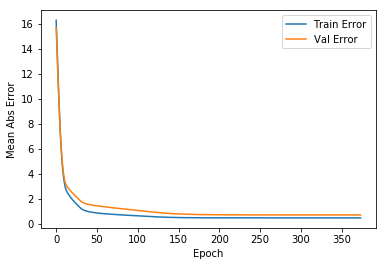

In [8]:
trainNNs(train)

# Test Time Functions

In [9]:
def copy_model(model):
    batch_model = keras.models.clone_model(model)
    batch_model.build((None, len(constants.CONTINUOUS_TRAINING_FEATURES)))
    batch_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    batch_model.set_weights(model.get_weights())
    
    return batch_model

def predictOneDataPoint(X):
    label = X.pop('PM2.5')
    X1 = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES])
    X2 = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES_W_PREV])
    online_pred = online_model.predict(X1)
    batch_pred = batch_model.predict(X1)
    online_w_prev_pred = online_model_w_prev.predict(X2)
    par_pred = par_model.predict(X1)
    
    return (online_pred[0], online_w_prev_pred[0], batch_pred[0], par_pred[0], label.iloc[0])
    

def getFullPredictions(data):
    online_predictions = []
    online_w_prev_predictions = []
    batch_predictions = []
    ensemble = []
    par_predictions = []
    baseline_predictions = []
    all_labels = []
       
    for i in range(len(data)):
#     for i in range(1522, 1523):
#         print(i)
        newData = data.iloc[[i]]
        
        online_pred, online_w_prev_pred, batch_pred, par_pred, label = predictOneDataPoint(newData)
        online_predictions.append(online_pred)
        par_predictions.append(par_pred)
        online_w_prev_predictions.append(online_w_prev_pred)
        batch_predictions.append(batch_pred)
        
        ensemble_pred = (.5 * online_pred) + (.5 * online_w_prev_pred)
        
        ensemble.append(ensemble_pred)
        all_labels.append(label)
        updateModels(newData, label)
    return (online_predictions, online_w_prev_predictions, batch_predictions, ensemble, all_labels, par_predictions)

In [10]:
batch_model = copy_model(online_model)
online_preds, online_w_prev_preds, batch_predictions, ensemble_preds, labels, par_preds = getFullPredictions(valid)
print(mean_absolute_error(online_preds, labels))
print(mean_absolute_error(online_w_prev_preds, labels))
print(mean_absolute_error(batch_predictions, labels))
print(mean_absolute_error(ensemble_preds, labels))
print(mean_absolute_error(par_preds, labels))

0.28147143020557924
0.2693950436883941
0.3786294247620689
0.24822683203019794
0.5600666179256305


In [11]:
np.mean(np.abs(np.diff(labels)))

0.44649901596621133

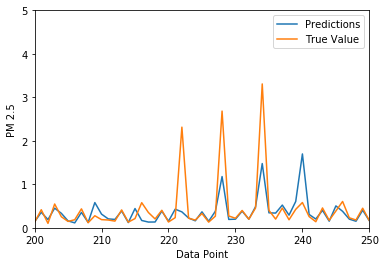

In [24]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Data Point')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,5])
    plt.xlim([200, 250])
    plt.legend()

    plt.show()

plot_preds(ensemble_preds, labels)